In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import os, kagglehub

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import kagglehub

path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to breast cancer images:", path)

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to breast cancer images: /kaggle/input/breast-ultrasound-images-dataset


In [3]:
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
base_dir = os.path.join(path, 'Dataset_BUSI_with_GT')

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_dataset = datasets.ImageFolder(root=base_dir, transform=data_transforms)
valid_indices = [i for i, (p, _) in enumerate(full_dataset.imgs) if '_mask' not in p]
clean_dataset = Subset(full_dataset, valid_indices)

train_size = int(0.8 * len(clean_dataset))
test_size = len(clean_dataset) - train_size
train_data, test_data = random_split(clean_dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train: {len(train_data)} | Test: {len(test_data)}")

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Train: 624 | Test: 156


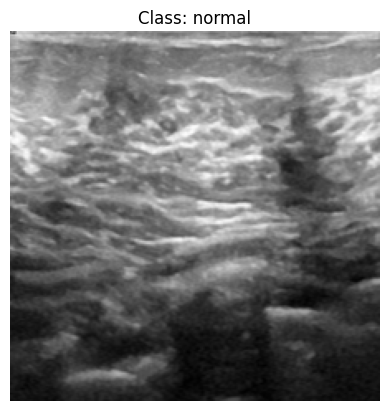

In [4]:
img, lbl = next(iter(train_loader))
plt.imshow(img[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title(f"Class: {full_dataset.classes[lbl[0]]}"); plt.axis('off'); plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_classes = 3
latent_e = 100
latent_c = 200

class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambd * grad_output, None

def grad_reverse(x, lambd=1.0):
    return GradReverse.apply(x, lambd)

def kl_standard_normal(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

class ConditionalPrior(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super().__init__()
        self.mu = nn.Embedding(n_classes, latent_dim)

    def forward(self, y):
        return self.mu(y)

def kl_to_class_prior(mu, logvar, y, prior_mu):
    d = mu.size(1)
    term = 1 + logvar - (mu - prior_mu).pow(2) - logvar.exp()
    return -0.5 * torch.mean(torch.sum(term, dim=1)) / d

class Encoder(nn.Module):
    def __init__(self, latent_dim_e, latent_dim_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7)),
        )
        self.flatten_dim = 128 * 7 * 7
        self.mu_e = nn.Linear(self.flatten_dim, latent_dim_e)
        self.lv_e = nn.Linear(self.flatten_dim, latent_dim_e)
        self.mu_c = nn.Linear(self.flatten_dim, latent_dim_c)
        self.lv_c = nn.Linear(self.flatten_dim, latent_dim_c)

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        me, lve = self.mu_e(h), self.lv_e(h)
        mc, lvc = self.mu_c(h), self.lv_c(h)
        ze = self.reparameterize(me, lve)
        zc = self.reparameterize(mc, lvc)
        return ze, me, lve, zc, mc, lvc

class Decoder(nn.Module):
    def __init__(self, latent_dim_e, latent_dim_c):
        super().__init__()
        self.fc = nn.Linear(latent_dim_e + latent_dim_c, 128 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 1, 1, 0), nn.Tanh(),
        )

    def forward(self, ze, zc):
        z = torch.cat([ze, zc], dim=1)
        return self.deconv(self.fc(z))

class AdversarialClassifier(nn.Module):
    def __init__(self, latent_dim_e, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim_e, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, ze_or_me):
        return self.net(ze_or_me)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(latent_e, latent_c).to(device)
decoder = Decoder(latent_e, latent_c).to(device)
adversarial = AdversarialClassifier(latent_e, n_classes).to(device)
cprior = ConditionalPrior(n_classes, latent_c).to(device)

opt_vae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(cprior.parameters()), lr=5e-4)
opt_adv = optim.Adam(adversarial.parameters(), lr=5e-4)

In [7]:
img, lbl = next(iter(train_loader))

print(f"Batch shape (Batch, Channels, Height, Width): {img.shape}")

print(f"Single image shape (Channels, Height, Width): {img[0].shape}")

Batch shape (Batch, Channels, Height, Width): torch.Size([64, 3, 224, 224])
Single image shape (Channels, Height, Width): torch.Size([3, 224, 224])


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Encoder params: {count_parameters(encoder):,}")
print(f"Decoder params: {count_parameters(decoder):,}")
print(f"Adversarial params: {count_parameters(adversarial):,}")

total_params = count_parameters(encoder) + count_parameters(decoder) + count_parameters(adversarial)
print(f"Total system parameters: {total_params:,}")

Encoder params: 4,454,904
Decoder params: 2,388,547
Adversarial params: 92,419
Total system parameters: 6,935,870


In [11]:
alpha, gamma, beta = 1.0, 1.0, 10.0
lambda_e = 0.1
mse_weight = 1.0
max_grad_norm = 1.0

for epoch in range(100):
    encoder.train(); decoder.train(); adversarial.train(); cprior.train()
    running_rec, running_kl, running_dis = 0.0, 0.0, 0.0
    grl_lambd = min(1.0, epoch / 40.0)

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt_adv.zero_grad(set_to_none=True)
        with torch.no_grad():
            _, me, _, _, _, _ = encoder(x)
        logits_adv = adversarial(me)
        l_adv_crit = F.cross_entropy(logits_adv, y)
        l_adv_crit.backward()
        opt_adv.step()

        opt_vae.zero_grad(set_to_none=True)
        ze, me, lve, zc, mc, lvc = encoder(x)

        r_full = decoder(ze, zc)
        with torch.no_grad():
            p_mu = cprior(y)
        r_ess = decoder(ze, p_mu)

        l_rec = (F.mse_loss(r_full, x) + (lambda_e * F.mse_loss(r_ess, x))) * mse_weight
        l_kl_e = kl_standard_normal(me, lve)
        l_kl_c = kl_to_class_prior(mc, lvc, y, p_mu)

        logits_dis = adversarial(grad_reverse(me, grl_lambd))
        l_dis = F.cross_entropy(logits_dis, y)

        l_total = l_rec + (alpha * l_kl_e) + (gamma * l_kl_c) + (beta * l_dis)
        l_total.backward()

        torch.nn.utils.clip_grad_norm_(
            list(encoder.parameters()) +
            list(decoder.parameters()) +
            list(cprior.parameters()),
            max_grad_norm
        )
        opt_vae.step()

        running_rec += l_rec.item()
        running_kl += (l_kl_e + l_kl_c).item()
        running_dis += l_dis.item()

    denom = len(train_loader)
    print(f"Epoch {epoch} | Rec: {running_rec/denom:.4f} | KL: {running_kl/denom:.4f} | Adv: {running_dis/denom:.4f}")

In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score

def collect_data(encoder, loader, device, use_mean=True):
    encoder.eval()
    feats_e, feats_c, ys = [], [], []
    with torch.inference_mode():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()
            ze, me, le, zc, mc, lc = encoder(x)
            fe = me if use_mean else ze
            fc = mc if use_mean else zc
            feats_e.append(fe.detach())
            feats_c.append(fc.detach())
            ys.append(y)
    return torch.cat(feats_e, dim=0), torch.cat(feats_c, dim=0), torch.cat(ys, dim=0)

def train_linear_probe(train_feat, train_y, test_feat, test_y, n_classes, class_names, device):
    model = nn.Linear(train_feat.size(1), n_classes).to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), max_iter=200, line_search_fn="strong_wolfe")
    criterion = nn.CrossEntropyLoss()

    train_feat = train_feat.detach().to(device)
    train_y = train_y.detach().to(device).long()
    test_feat = test_feat.detach().to(device)
    test_y = test_y.detach().to(device).long()

    def closure():
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(train_feat), train_y)
        loss.backward()
        return loss

    optimizer.step(closure)

    with torch.inference_mode():
        preds = model(test_feat).argmax(dim=1).cpu().numpy()
        true_y = test_y.cpu().numpy()

    acc = accuracy_score(true_y, preds)
    report = classification_report(true_y, preds, target_names=class_names, digits=2, zero_division=0)
    return acc, report

def evaluate_disentanglement(encoder, train_loader, test_loader, device, n_classes, class_names, use_mean=True):
    ze_tr, zc_tr, y_tr = collect_data(encoder, train_loader, device, use_mean=use_mean)
    ze_te, zc_te, y_te = collect_data(encoder, test_loader, device, use_mean=use_mean)

    res_ze = train_linear_probe(ze_tr, y_tr, ze_te, y_te, n_classes, class_names, device)
    res_zc = train_linear_probe(zc_tr, y_tr, zc_te, y_te, n_classes, class_names, device)
    return res_ze, res_zc


(acc_ze, report_ze), (acc_zc, report_zc) = evaluate_disentanglement(
    encoder, train_loader, test_loader, device,
    n_classes=len(full_dataset.classes),
    class_names=full_dataset.classes,
    use_mean=True
)

print(f"Accuracy via z_c: {acc_zc*100:.2f}%\n{report_zc}")
print("-" * 30)
print(f"Accuracy via z_e: {acc_ze*100:.2f}%\n{report_ze}")

Accuracy via z_c: 67.95%
              precision    recall  f1-score   support

      benign       0.78      0.70      0.74        91
   malignant       0.57      0.67      0.61        45
      normal       0.57      0.60      0.59        20

    accuracy                           0.68       156
   macro avg       0.64      0.66      0.65       156
weighted avg       0.69      0.68      0.68       156

------------------------------
Accuracy via z_e: 58.97%
              precision    recall  f1-score   support

      benign       0.71      0.62      0.66        91
   malignant       0.56      0.56      0.56        45
      normal       0.34      0.55      0.42        20

    accuracy                           0.59       156
   macro avg       0.54      0.57      0.55       156
weighted avg       0.62      0.59      0.60       156



In [11]:
def evaluate_proximity_disentanglement(encoder, train_loader, test_loader, device, class_names):
    ze_tr, zc_tr, y_tr = collect_data(encoder, train_loader, device)
    ze_te, zc_te, y_te = collect_data(encoder, test_loader, device)

    def get_report(tr_feat, te_feat, tr_y, te_y):
        unique_classes = torch.unique(tr_y)
        centroids = torch.stack([tr_feat[tr_y == c].mean(0) for c in unique_classes])

        dists = torch.cdist(te_feat, centroids)
        preds = torch.argmin(dists, dim=1).cpu().numpy()
        true_y = te_y.cpu().numpy()

        acc = accuracy_score(true_y, preds)
        report = classification_report(true_y, preds, target_names=class_names, digits=2, zero_division=0)
        return acc, report

    res_zc = get_report(zc_tr, zc_te, y_tr, y_te)
    res_ze = get_report(ze_tr, ze_te, y_tr, y_te)
    return res_ze, res_zc

(acc_ze, report_ze), (acc_zc, report_zc) = evaluate_proximity_disentanglement(
    encoder, train_loader, test_loader, device,
    class_names=full_dataset.classes
)

print(f"Accuracy via z_c (Centroid Proximity): {acc_zc*100:.2f}%\n{report_zc}")
print("-" * 30)
print(f"Accuracy via z_e (Centroid Proximity): {acc_ze*100:.2f}%\n{report_ze}")

Accuracy via z_c (Centroid Proximity): 55.13%
              precision    recall  f1-score   support

      benign       0.75      0.60      0.67        91
   malignant       0.45      0.56      0.50        45
      normal       0.21      0.30      0.25        20

    accuracy                           0.55       156
   macro avg       0.47      0.49      0.47       156
weighted avg       0.60      0.55      0.57       156

------------------------------
Accuracy via z_e (Centroid Proximity): 57.69%
              precision    recall  f1-score   support

      benign       0.72      0.70      0.71        91
   malignant       0.42      0.38      0.40        45
      normal       0.33      0.45      0.38        20

    accuracy                           0.58       156
   macro avg       0.49      0.51      0.50       156
weighted avg       0.58      0.58      0.58       156

